# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста. 

Вашей метрикой качества будет MAE.

Данные взяты с сайта [ChaLearn Looking at People](http://chalearnlap.cvc.uab.es/dataset/26/description/). Они находятся в папке `/datasets/faces/`.
В вашем распоряжении одна папка со всеми изображениями (`/final_files`) и csv-файл `labels.csv` с двумя колонками: *file_name* и *real_age*.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import statsmodels.api as sm
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Исследовательский анализ данных

Загрузим данные и посмотрим на них.

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [3]:
print('Количество повторяющихся строк:', labels.duplicated().sum())
print('Количество уникальных имён файла:', labels['file_name'].nunique())
print()
labels.info()

Количество повторяющихся строк: 0
Количество уникальных имён файла: 7591

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


В таблице 7591 строка, дубликатов нет. Каждая строка соответствует изображению. Возраст человека на фотографии представлен в виде целого числа. Пропусков в таблице нет.

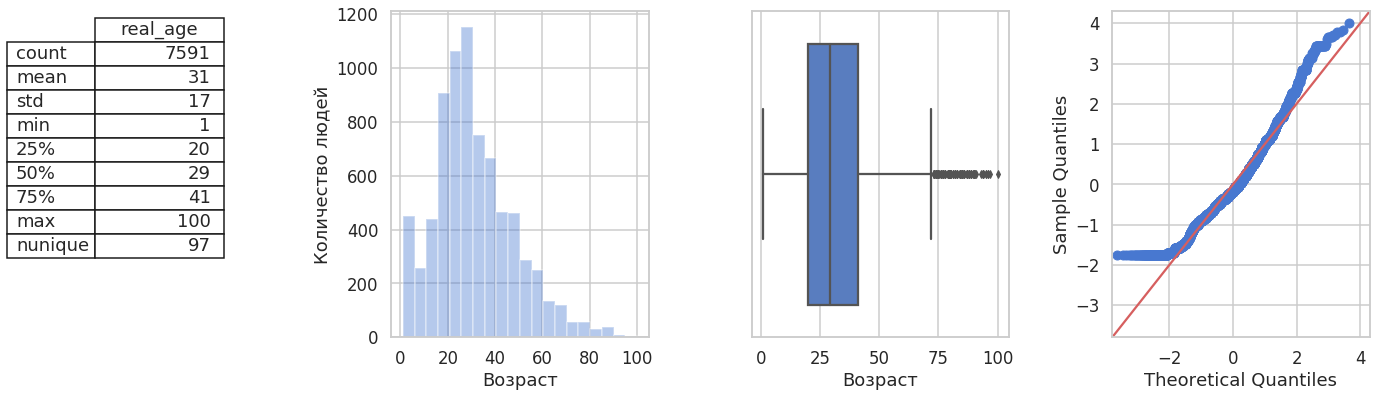

In [4]:
age_descr = (
    labels['real_age'].describe()
    .append(pd.Series({'nunique': labels['real_age'].nunique()}))
    .map(round)
    .to_frame('real_age')
)

sns.set(context='talk', style='whitegrid', palette='muted')
f, ax = plt.subplots(1, 4, gridspec_kw={'wspace': 0.4})
f.set_figheight(6)
f.set_figwidth(24)

the_table = ax[0].table(
    #Содержимое таблицы в виде списка списков строк
    cellText = [list(x) for x in age_descr.values.astype('str')],
    rowLabels = list(age_descr.index),
    colLabels = ['real_age'],
    loc = 'upper center',
    colWidths = [0.5],
)
the_table.scale(1, 2)
the_table.auto_set_font_size(False)
the_table.set_fontsize(18)
ax[0].grid(False)
ax[0].axis('off')

sns.distplot(
    labels['real_age'],
    kde=False,
    hist=True,
    bins=20,
    ax=ax[1]
)
ax[1].set(xlabel='Возраст', ylabel='Количество людей')
ax[1].xaxis.set_major_locator(ticker.MultipleLocator(20))

sns.boxplot(
    x = 'real_age',
    data = labels,
    orient = 'h',
    ax = ax[2]
)
ax[2].set(xlabel='Возраст', ylabel='')
ax[2].xaxis.set_major_locator(ticker.MultipleLocator(25))

sm.qqplot(labels['real_age'], line='45', fit=True, ax=ax[3])
plt.show()

Возраст людей находится в диапазоне значений от 1 года до 100 лет, при этом уникальных значений 97. Это значит, не все варианты значений возраста от 1 до 100 представлены на фотографиях, для некоторых возрастов нет примеров. 

Медианное значение возраста - 29, среднее 31 - близко, но сдвинуто вправо. У распределения длинный правый хвост. Для людей старше 60 примеров изображений существенно меньше, чем для тех, кто младше этого возраста. На ящике с усами возрастные люди отмечены как выбросы, но это реальные люди.

В выборке есть достаточно много изображений маленьких детей. Распределение слева сильно отличается от нормального.

Посмотрим на гистограмму подробнее.

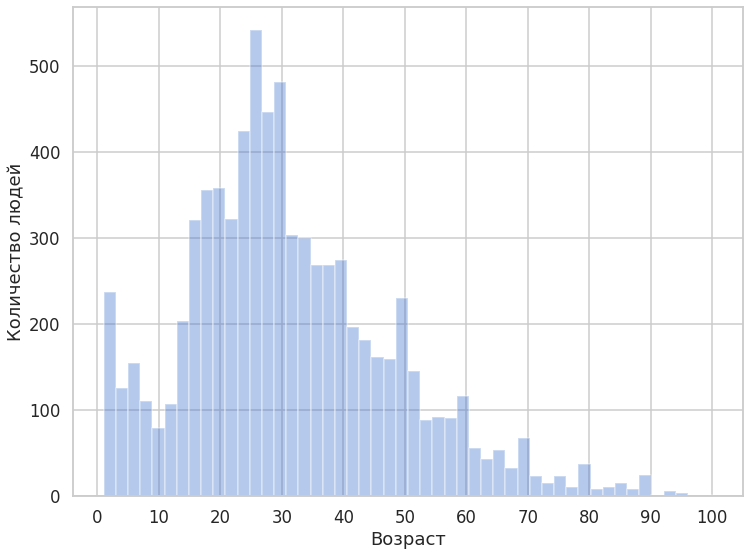

In [5]:
plt.figure(figsize=(12, 9))

ax = sns.distplot(
    labels['real_age'],
    kde=False,
    hist=True,
    bins=50
)

ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
plt.xlabel('Возраст')
plt.ylabel('Количество людей')
plt.show()

Для детей 1-го года примеров изображений существенно больше, чем для детей других возрастов. При этом для 10-летних детей представлено достаточно мало фотографий, меньше, чем, например, для 55-летних взрослых.

Начиная с 50 лет на гистограмме видны пики каждые 10 лет. По какой-то причине фотографий людей круглого возраста оказалось больше. Возможно, люди чаще фотографируются на юбилей, поэтому найти такие фотографии проще или их в принципе существует больше. Другая возможная причина - возраст указан неточно, есть некоторая апроксимация. Может быть, для некоторых фотографий информации о возрасте не было и её восстанавливали искусственно. Этот вариант для обучения модели был бы хуже. Для точного понимания причин нужно знать, как был собран датасет.

Для примера посмотрим на 12 изображений.

Found 7591 validated image filenames.


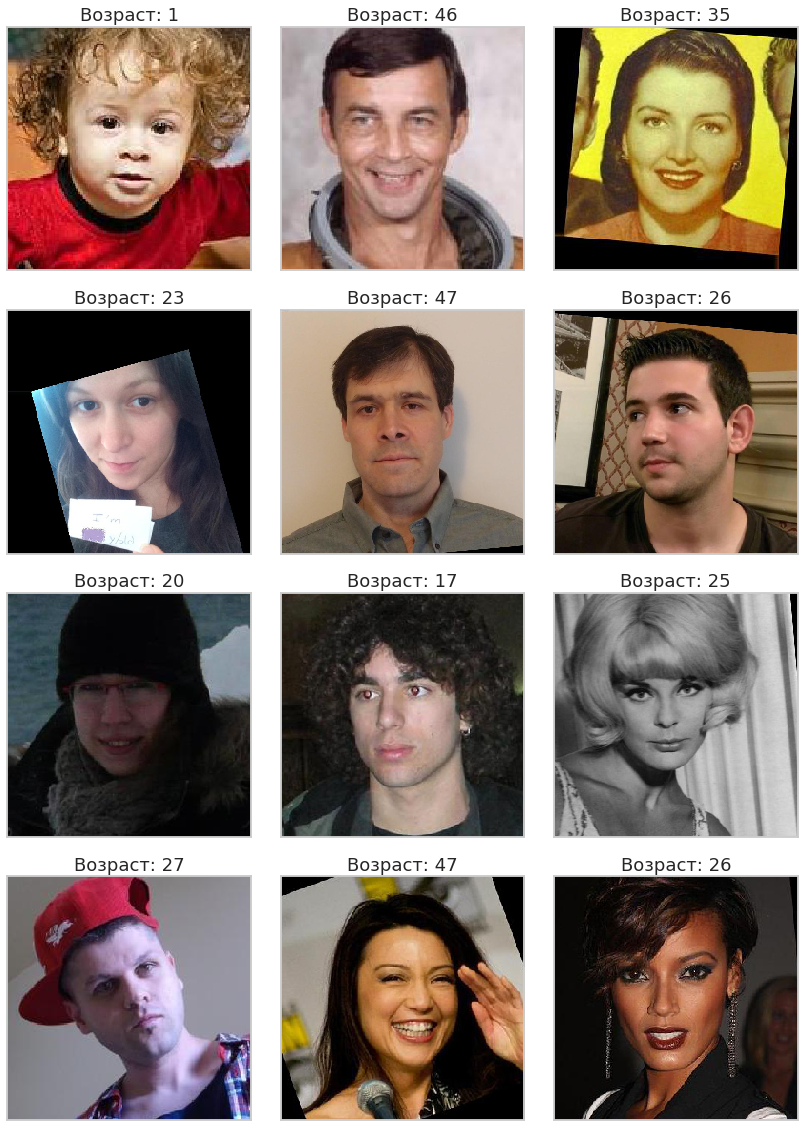

In [6]:
datagen = ImageDataGenerator(rescale=1/255)

datagen_flow = datagen.flow_from_dataframe(
    labels,
    '/datasets/faces/final_files',
    x_col='file_name',
    y_col='real_age',
    target_size=(256, 256),
    batch_size=12,
    class_mode='raw',
    seed=42
)

faces, ages = next(datagen_flow)

fig = plt.figure(figsize=(12,16))
for i in range(12):
    fig.add_subplot(4, 3, i+1)
    plt.imshow(faces[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.title('Возраст: ' + str(ages[i]))

Среди фотографий есть цветные и чёрно-белые, причём у цветных - разная палитра. Лица не всегда находятся в центре кадра, могут быть повёрнуты на некоторый угол и частично обрезаны, также среди изображений есть отражения в зеркале. Не на всех фотографиях люди строго анфас, выражения лиц тоже разные.

**Вывод**

Выборка представляет собой 7591 фотографию людей в возрасте от 1 до 100 лет. Медианный возраст - 29 лет. В распределении есть дополнительный пик слева, который приходится на маленьких детей, и длинный правый хвост. Это означает, что у модели будет мало примеров людей в возрасте, т.е. чем старше человек, тем сильнее будет ошибаться модель в своём прогнозе.

Лица на фотографиях в датасете могут быть повёрнуты на некоторый угол, смещенны от центра или представлены в виде отражения в зеркале. Поэтому можно попробовать соответствующие аугментации для обучающей выборки: rotation_range, width_shift_range, height_shift_range, horizontal_flip.

## Обучение модели

(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

Для правильной работы тренажёра код должен содержать четыре функции:
- `load_train(path)`
- `load_test(path)`
- `create_model(input_shape)`
- `train_model(model, train_data, test_data, batch_size, epochs, steps_per_epoch, validation_steps)`

```python
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd


def memo(func):
    results = {}
    def wrapper(arg):
        if arg in results:
            result = results[arg]
        else:
            result = func(arg)
            results[arg] = result
        return result
    return wrapper

# Чтобы дважды не скачивать датафрейм
@memo
def get_flow_params(path):
    flow_params = {
        'dataframe': pd.read_csv(path + 'labels.csv'),
        'directory': path + 'final_files',
        'x_col': 'file_name',
        'y_col': 'real_age',
        'class_mode': 'raw',
        'target_size': (256, 256),
        'batch_size': 16,
        'seed': 42
        }
    return flow_params


def load_train(path):
    datagen = ImageDataGenerator(
        rescale=1/255, validation_split = 0.25,
        horizontal_flip=True,
        rotation_range=30,
        width_shift_range=0.1,
        height_shift_range=0.1
        ) 
    flow_params = get_flow_params(path)
    datagen_flow = datagen.flow_from_dataframe(subset='training', **flow_params)
    return datagen_flow


def load_test(path):
    datagen = ImageDataGenerator(rescale=1/255, validation_split = 0.25) 
    flow_params = get_flow_params(path)
    datagen_flow = datagen.flow_from_dataframe(subset='validation', **flow_params)
    return datagen_flow


def create_model(input_shape):
    optimizer = Adam(lr=0.0001)
    backbone = ResNet50(
        input_shape=input_shape, 
        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', 
        include_top=False
        )
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model


def train_model(model, train_data, test_data, batch_size=None, 
                epochs=150, steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    callback = EarlyStopping(monitor='val_mae', min_delta=0.01, patience=10, restore_best_weights=True)
    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True,
              callbacks=[callback]
              )

    return model
```

```
Found 5694 validated image filenames.
Found 1897 validated image filenames.

Train for 356 steps, validate for 119 steps
Epoch 1/150
356/356 - 207s - loss: 223.4558 - mae: 10.9380 - val_loss: 630.9089 - val_mae: 19.9187
Epoch 2/150
356/356 - 114s - loss: 112.2704 - mae: 8.0412 - val_loss: 249.3870 - val_mae: 12.0139
Epoch 3/150
356/356 - 115s - loss: 92.4306 - mae: 7.3459 - val_loss: 88.0873 - val_mae: 7.2166
Epoch 4/150
356/356 - 113s - loss: 77.7123 - mae: 6.6798 - val_loss: 87.3185 - val_mae: 6.9558
Epoch 5/150
356/356 - 113s - loss: 68.4318 - mae: 6.2529 - val_loss: 96.0855 - val_mae: 7.1340
Epoch 6/150
356/356 - 114s - loss: 63.3284 - mae: 6.0972 - val_loss: 87.1616 - val_mae: 7.0685
Epoch 7/150
356/356 - 115s - loss: 55.8002 - mae: 5.6951 - val_loss: 79.9133 - val_mae: 6.8646
Epoch 8/150
356/356 - 114s - loss: 45.8972 - mae: 5.2355 - val_loss: 70.8694 - val_mae: 6.2529
Epoch 9/150
356/356 - 114s - loss: 42.2944 - mae: 5.0216 - val_loss: 92.4652 - val_mae: 7.2754
Epoch 10/150
356/356 - 115s - loss: 38.6467 - mae: 4.7579 - val_loss: 73.1013 - val_mae: 6.4211
Epoch 11/150
356/356 - 114s - loss: 33.8606 - mae: 4.4814 - val_loss: 105.9906 - val_mae: 7.7670
Epoch 12/150
356/356 - 113s - loss: 32.5249 - mae: 4.3928 - val_loss: 74.9280 - val_mae: 6.5869
Epoch 13/150
356/356 - 114s - loss: 28.4644 - mae: 4.1170 - val_loss: 80.8482 - val_mae: 6.6700
Epoch 14/150
356/356 - 115s - loss: 26.7589 - mae: 3.9944 - val_loss: 74.5629 - val_mae: 6.6360
Epoch 15/150
356/356 - 115s - loss: 25.1864 - mae: 3.8946 - val_loss: 95.2940 - val_mae: 7.2971
Epoch 16/150
356/356 - 114s - loss: 32.7042 - mae: 4.3287 - val_loss: 70.5993 - val_mae: 6.1273
Epoch 17/150
356/356 - 114s - loss: 29.1481 - mae: 4.1143 - val_loss: 89.2902 - val_mae: 7.2311
Epoch 18/150
356/356 - 114s - loss: 26.5507 - mae: 3.9491 - val_loss: 70.5364 - val_mae: 6.3964
Epoch 19/150
356/356 - 114s - loss: 20.9933 - mae: 3.5308 - val_loss: 65.5062 - val_mae: 5.9340
Epoch 20/150
356/356 - 115s - loss: 19.5780 - mae: 3.4014 - val_loss: 74.2248 - val_mae: 6.4576
Epoch 21/150
356/356 - 114s - loss: 18.3553 - mae: 3.2778 - val_loss: 71.2119 - val_mae: 6.0625
Epoch 22/150
356/356 - 114s - loss: 17.6947 - mae: 3.2523 - val_loss: 63.4627 - val_mae: 5.7945
Epoch 23/150
356/356 - 114s - loss: 16.3240 - mae: 3.1009 - val_loss: 63.8191 - val_mae: 5.7811
Epoch 24/150
356/356 - 113s - loss: 16.7180 - mae: 3.1147 - val_loss: 83.7240 - val_mae: 7.0874
Epoch 25/150
356/356 - 115s - loss: 15.7527 - mae: 3.0545 - val_loss: 65.7265 - val_mae: 5.9070
Epoch 26/150
356/356 - 114s - loss: 16.5213 - mae: 3.1056 - val_loss: 64.1783 - val_mae: 5.7425
Epoch 27/150
356/356 - 114s - loss: 16.7348 - mae: 3.1676 - val_loss: 65.4015 - val_mae: 6.0570
Epoch 28/150
356/356 - 115s - loss: 17.5295 - mae: 3.2068 - val_loss: 66.6802 - val_mae: 5.9702
Epoch 29/150
356/356 - 116s - loss: 16.1279 - mae: 3.0721 - val_loss: 72.3638 - val_mae: 6.0265
Epoch 30/150
356/356 - 115s - loss: 23.8853 - mae: 3.5323 - val_loss: 84.8539 - val_mae: 6.8243
Epoch 31/150
356/356 - 114s - loss: 20.2925 - mae: 3.4159 - val_loss: 65.2318 - val_mae: 5.9131
Epoch 32/150
356/356 - 115s - loss: 13.2105 - mae: 2.8158 - val_loss: 62.6026 - val_mae: 5.7510
Epoch 33/150
356/356 - 114s - loss: 10.8923 - mae: 2.5477 - val_loss: 59.9046 - val_mae: 5.5560
Epoch 34/150
356/356 - 113s - loss: 10.1922 - mae: 2.4746 - val_loss: 70.2093 - val_mae: 6.1756
Epoch 35/150
356/356 - 114s - loss: 9.9224 - mae: 2.4223 - val_loss: 64.1692 - val_mae: 5.9487
Epoch 36/150
356/356 - 115s - loss: 10.7616 - mae: 2.5347 - val_loss: 69.9876 - val_mae: 6.0795
Epoch 37/150
356/356 - 116s - loss: 10.6721 - mae: 2.5086 - val_loss: 63.7647 - val_mae: 5.7955
Epoch 38/150
356/356 - 113s - loss: 11.8884 - mae: 2.6399 - val_loss: 64.3152 - val_mae: 5.9043
Epoch 39/150
356/356 - 114s - loss: 10.5711 - mae: 2.4935 - val_loss: 71.8492 - val_mae: 6.0762
Epoch 40/150
356/356 - 114s - loss: 10.8754 - mae: 2.5379 - val_loss: 66.4669 - val_mae: 5.8846
Epoch 41/150
356/356 - 115s - loss: 11.8253 - mae: 2.6126 - val_loss: 78.8939 - val_mae: 6.3841
Epoch 42/150
356/356 - 114s - loss: 11.3605 - mae: 2.5796 - val_loss: 64.6210 - val_mae: 5.8121
Epoch 43/150
356/356 - 115s - loss: 13.8816 - mae: 2.7838 - val_loss: 67.3900 - val_mae: 5.9992

119/119 - 10s - loss: 59.9046 - mae: 5.5560
Test MAE: 5.5560
```

## Анализ обученной модели

Для решения задачи использована предобученная сеть ResNet50, два последних слоя которой заменены вручную на GlobalAveragePooling2D и Dense с одним нейроном и функций активации ReLU. Использован алгоритм обучения Adam со значением learninr rate = 0,0001. Функция потерь - MSE. После 33-х эпох значение MAE на валидационной выборке составило 5,56 лет и следующие 10 эпох не улучшалось, что привело к ранней остановке процесса и возвращению к лучшему результату. При этом сеть переобучилась: на 33-ей эпохе на обучающей выборке MAE = 2,55 лет.

Не смотря на переобучение, сеть может давать хороший прогноз с ошибкой в 5-6 лет, что позволяет определить, к какой возрастной группе относится клиент. Однако для продажи алкоголя такого результата недостаточно. Если сеть определила возраст клиента в диапазоне от 12 до 24 лет - требуется дополнительная проверка возраста, чтобы узнать точно, исполнилось ли человеку 18. 

## Чек-лист

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [x]  MAE модели не больше 8
- [x]  Код обучения модели скопирован в финальную тетрадь
- [x]  Результат вывода модели на экран перенесён в финальную тетрадь
- [x]  По итогам обучения модели сделаны выводы